## Exercise 1.
#### Stochastic Firms wih quadratic adjustment cost

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numba import jit

# to print plots inline
%matplotlib inline

In [3]:
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
betafirm = (1 / (1 + r))
sigma_eps = 0.213
rho = 0.7605
sigma_z = sigma_eps / ((1 - rho ** 2) ** (1 / 2))
mu = 0.0
N = 9

num_draws = 100000 # number of shocks to draw
eps = np.random.normal(0.0, sigma_z, size=(num_draws))

z = np.empty(num_draws)
z[0] = 0.0 + eps[0]
for i in range(1, num_draws):
    z[i] = rho * z[i - 1] + (1 - rho) * mu + eps[i]

In [8]:
# compute grid points for z
from scipy.stats import norm

# Compute cut-off values
N = 9  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)

z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', z_grid)

Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]
Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [6]:
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu *
                                  (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
#print('Transition matrix = ', pi)
#print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))

In [7]:
z_shocks = np.exp(z_grid)
z_shocks.shape

(9,)

### Discretizing the state space for the capital stock 

In [6]:
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

### Calculate the Profits for all realization s of the productivity shocks

In [7]:
# operating profits, op pi function in the
def op_ret(alpha_l, alpha_k, w, z, kvec):
    opp = (1 - alpha_l) * (alpha_l / w) ** (alpha_l / (1 - alpha_l)) * (kvec ** (alpha_k / (1 - alpha_l))) * z ** (1 / (1 -alpha_l))
    return opp

def cost_fun(psi, delta, k, k_prime):
    adj_cost = (psi / 2) * ((k_prime - ((1 - delta) * k)) ** 2) / k
    net_invest_cost = k_prime - (1 - delta) * k
    
    total_cost = adj_cost + net_invest_cost
    return total_cost

# firm cash flow, e
e = np.zeros((sizek, sizek, len(z_shocks)))
for k in range(len(z_shocks)):
    z = z_shocks[k]
    op = op_ret(alpha_l, alpha_k, w, z, kvec)
    for i in range(sizek):
        for j in range(sizek):
            e[i, j, k] = op[i] - cost_fun(psi, delta, k=kvec[i], k_prime=kvec[j])

In [8]:
op.shape

(57,)

In [9]:
@jit
def get_VF(V_init, Vmat, e, shocks, sizek):

    for k in range(len(shocks)): # looop over z'
        z = shocks[k]
        for i in range(sizek):  # loop over k
            for j in range(sizek):  # loop over k'
                Vmat[i, j, k] = e[i, j, k] + betafirm * V_init[j, k]
        
    
    return Vmat

In [10]:
VFmaxiter = 3000
Vstore = np.zeros((sizek, VFmaxiter, len(z_shocks)))  # initialize Vstore array

In [42]:
def VFI(Val_fun=None, profits = None, z_shocks=None, sizek=None, Vstore=None, VFtol=1e-6, VFmaxiter=3000):
    
    PF = np.ones((len(z_shocks), sizek), dtype=int)
    total_start_time = time.clock()
    #for k in range(len(z_shocks)):
    V = np.zeros((sizek, len(z_shocks)))  # initial guess at value function
    Vmat = np.zeros((sizek, sizek, N))  # initialize Vmat matrix
    VFiter = 1
    VFdist = 3
    
    start_time = time.clock()
    while VFdist > VFtol and VFiter < VFmaxiter:
        
        TV = np.copy(V)
        TV_e = TV @ pi.T
        
        Vmat = Val_fun(TV_e, Vmat, profits, z_shocks, sizek)
                        
        V = Vmat.max(axis=1)                    # apply max operator to Vmat (to get V(k))
        Vstore[:, VFiter, :] = V     # store value function at each iteration for graphing later
        VFdist = (np.absolute(V - TV)).max()
        
        VFiter += 1

    if VFiter < VFmaxiter:
        print('\nValue function converged after', VFiter, 'iterations')
        #print('VFI took ', VFI_time, ' seconds to solve')
    else:
        print('Value function did not converge')

    PF = np.argmax(Vmat, axis=1)
    time_elapsed = time.clock() - total_start_time
    print('\ntotal time elapsed:', time_elapsed, 'seconds')
    
    return V, PF , Vstore

In [43]:
VFs, PF, Vstore = VFI(get_VF, e, z_shocks, sizek, Vstore, VFmaxiter=3000)


Value function converged after 366 iterations

total time elapsed: 0.10967315389893884 seconds


In [44]:
def plot_valfuns(kvec, VFs):
    _, Num = VFs.shape 
    fig, ax = plt.subplots(figsize=(9, 6))
    #ax.set_ylim(-40, 10)
    ax.set_xlim(np.min(kvec), np.max(kvec))
    for k in range(Num):
        lb = 'z={}'.format(np.around(z_shocks[k], 2))
        ax.plot(kvec, VFs[:,k], color=plt.cm.jet(k / Num), lw=2, alpha=0.6, label=lb)
    
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.ylabel('Value Function')
    plt.xlabel('Size of Capital Stock')
    plt.title('Value Function')
    plt.show()


# plt.plot(kvec, VFs[4,:], 'k')
# plt.xlabel('Size of Capital Stock')
# plt.ylabel('Value Function')
# plt.title('Value Function - deterministic firm w/ adjustment costs')
# plt.show();

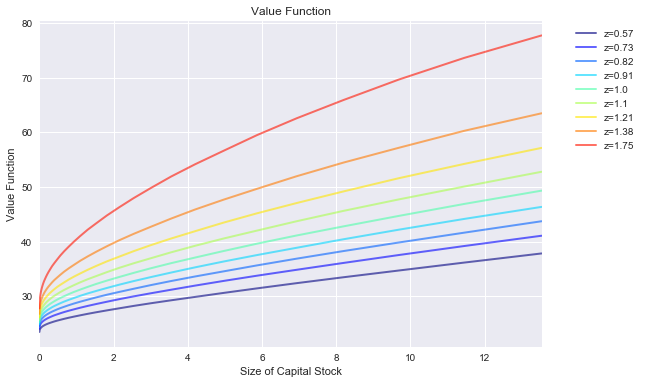

In [45]:
plot_valfuns(kvec, VFs)

In [46]:
#### choose one of the nine shocks

#optK = kvec[PF[0,:]]
#optI = optK - (1 - delta) * kvec

# Plot optimal capital stock rule as a function of firm size
def plot_policy(kvec, PF, z_shocks):
    fig, ax = plt.subplots()
    for k in range(len(z_shocks)):
        optK = kvec[PF[:,k]]
        optI = optK - (1 - delta) * kvec
        lb = 'z={}'.format(np.around(z_shocks[k], 2))
        ax.plot(kvec, optK, '--', color=plt.cm.jet(k / N), lw=2, alpha=0.8, label=lb)
    ax.plot(kvec, kvec, 'k:', label='45 degree line')
    # Now add the legend with some customizations.
    legend = ax.legend(bbox_to_anchor=(1.0, 1.05), shadow=True)
    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')
    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Function for initial states of z')
    plt.show();

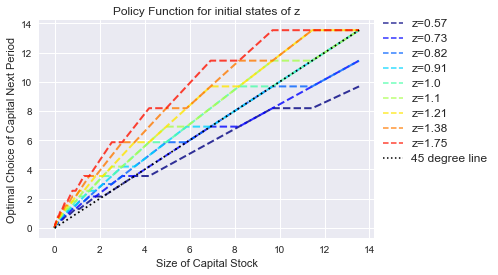

In [47]:
plot_policy(kvec, PF, z_shocks)

## Exercise 2. 
#### Stochastic Firms with fixed adjustment cost

In [48]:
# Set parameter on fixed cost for investment
psi_1 = 0.03

In [49]:
# compute casho flows for firms that iundertake investment ('active')
e_active = np.zeros((sizek, sizek, len(z_shocks)))    # cash flows with investmant
for k in range(len(z_shocks)):
    z = z_shocks[k]
    op = op_ret(alpha_l, alpha_k, w, z, kvec)
    for i in range(sizek): #loop over k
        for j in range(sizek): # loop over k'
            e_active[i, j, k] = op[i] - psi_1 * kvec[i] - kvec[j] + (1 - delta) * kvec[i]

In [50]:
VFmaxiter = 3000
Vstore_fix = np.zeros((sizek, VFmaxiter, len(z_shocks))) 

### Compute value of the value function when not investring

In [51]:
# compute cash flows of firms wich do not invest ('inactive')
e_inactive = np.zeros((sizek, len(z_shocks)))    # cash flows without investmant
for k in range(len(z_shocks)):
    z = z_shocks[k]
    op = op_ret(alpha_l, alpha_k, w, z, kvec)
    for i in range(sizek): #loop over k
        e_inactive[i, k] = op[i]  # they have no investment cost so profots equal cash flows

In [52]:
# define the Value function iteration for firms that do not invest
@jit
def get_VF_inactive(V_init, Vmat, flows, shocks, sizek):
    for k in range(len(shocks)):
            for i in range(sizek):  # loop over k
                if i == 0:
                    Vmat[i, k] = flows[i, k] + betafirm * V_init[i, k]
                else:
                    # index [i-dens] picks the value of V for the one period derpreciated capital
                    Vmat[i, k] = flows[i, k] + betafirm * V_init[i - dens, k] 
    return Vmat

In [77]:
def VFI_fixed(Val_fun_active=None, Val_fun_inactive=None, flows_active = None, flows_inactive=None,
              z_shocks=None, pi = None, sizek=None, Vstore=None, VFtol=1e-6, VFmaxiter=3000):
    
    PF_active = np.ones((sizek, len(z_shocks)), dtype=int)
    PF_inactive = np.repeat(np.concatenate((np.zeros(1, dtype=int), np.arange(sizek-dens))), 9).reshape((57, 9))
    total_start_time = time.clock()
    #for k in range(len(z_shocks)):
    V_inactive = np.zeros((sizek, len(z_shocks)))
    V_opt =  np.copy(V_inactive) # initial guess at value function
    Vmat_active = np.zeros((sizek, sizek, N))  # initialize Vmat matrix
    VFiter = 1
    VFdist = 3
    
    start_time = time.clock()
    while VFdist > VFtol and VFiter < VFmaxiter:
        
        TV = np.copy(V_opt)
        TV_e = TV @ pi.T
        
        Vmat_active = Val_fun_active(TV_e, Vmat_active, flows_active, z_shocks, sizek)
                      
        V_active = Vmat_active.max(axis=1)     # apply max operator to Vmat (to get V(k))
        PF_active = np.argmax(Vmat_active, axis=1)  # get the index of the k' that maximize the investment payoff
        
        V_inactive = Val_fun_inactive(TV_e, V_inactive, flows_inactive, z_shocks, sizek)

        inactive_is_optimal = V_inactive > V_active
        V_opt = np.copy(V_active)
        V_opt[inactive_is_optimal] = V_inactive[inactive_is_optimal]
        
        #Vstore[:, VFiter, :] = V     # store value function at each iteration for graphing later
        VFdist = (np.absolute(V_opt - TV)).max()
        
        VFiter += 1

    if VFiter < VFmaxiter:
        print('\nValue function converged after', VFiter, 'iterations')
        PF_active[inactive_is_optimal] = PF_inactive[inactive_is_optimal]
    else:
        print('Value function did not converge')

    
    time_elapsed = time.clock() - total_start_time
    print('\ntotal time elapsed:', time_elapsed, 'seconds')
    
    return V_opt, PF_active , inactive_is_optimal

In [81]:
V_invest, PF_invest, inactive_mask = VFI_fixed(get_VF, get_VF_inactive, e_active, e_inactive, z_shocks, pi, sizek, Vstore_fix)


Value function converged after 368 iterations

total time elapsed: 0.16156950166373463 seconds


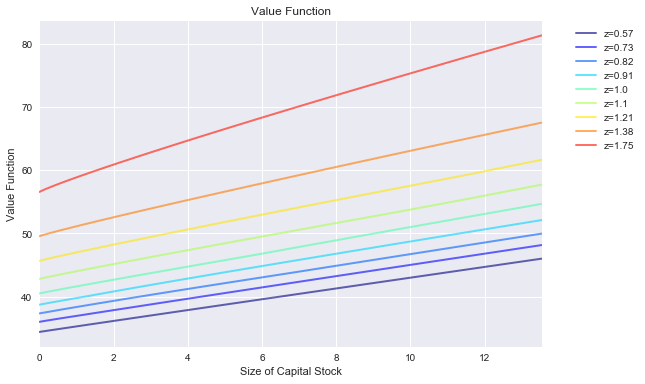

In [82]:
plot_valfuns(kvec, V_invest)

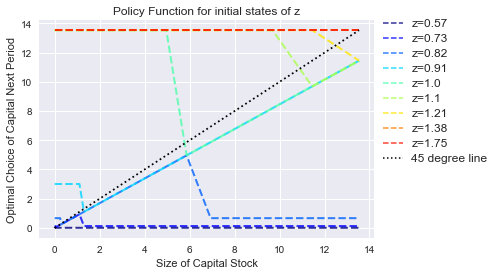

In [80]:
plot_policy(kvec, PF_invest, z_shocks)

Admitttedly, the policy function look pretty messed up and I have the feeling that they are not correct. At least, I can't think of any intuition for them to look like they do.

In [1]:
PF_inactive = np.repeat(np.concatenate((np.zeros(1, dtype=int), np.arange(sizek-dens))), 9).reshape((57, 9))


NameError: name 'np' is not defined

In [41]:
inactive_mask

array([[ True, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, 